# **Import Data**

In [ ]:
import numpy as np
np.random.seed(777)
import tensorflow as tf
np.random.seed(777)
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import os

In [ ]:
!git clone https://github.com/Zatan666/Acne_Image_classification

fatal: destination path 'Acne_Image_classification' already exists and is not an empty directory.


In [ ]:
import glob
folder_path = 'acne_img/'
file_paths = glob.glob(folder_path + '**/*', recursive=True)

# **Data Preprocessing**

In [ ]:
from tensorflow import keras
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns

In [ ]:
batch_size = 32
target_size = (150, 150)

In [ ]:
data_dir = '/content/Acne_Image_classification/acne_img'
datagen = ImageDataGenerator(rescale = 1./255, validation_split=0.25)

train_ds = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="training",
    seed=0,
    )

val_ds = datagen.flow_from_directory(
    data_dir,
    target_size=target_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset="validation",
    seed=0)


Found 261 images belonging to 5 classes.
Found 84 images belonging to 5 classes.


In [ ]:
class_names = list(train_ds.class_indices.keys())
print(class_names)

['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead']


In [ ]:
from collections import Counter
Counter(train_ds.classes)

Counter({0: 39, 1: 45, 2: 38, 3: 97, 4: 42})

In [ ]:
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight

weights = compute_class_weight(class_weight = "balanced",
                               classes = np.unique(train_ds.classes),
                               y = train_ds.classes)
weights

array([1.33846154, 1.16      , 1.37368421, 0.53814433, 1.24285714])

In [ ]:
cw = dict(zip(np.unique(train_ds.classes), weights))
cw

{0: 1.3384615384615384,
 1: 1.16,
 2: 1.3736842105263158,
 3: 0.5381443298969072,
 4: 1.2428571428571429}

In [ ]:
train_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=0,
    image_size=target_size,
    batch_size=batch_size)

val_ds = keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="validation",
    seed=0,
    image_size=target_size,
    batch_size=batch_size)

Found 345 files belonging to 5 classes.
Using 259 files for training.
Found 345 files belonging to 5 classes.
Using 86 files for validation.


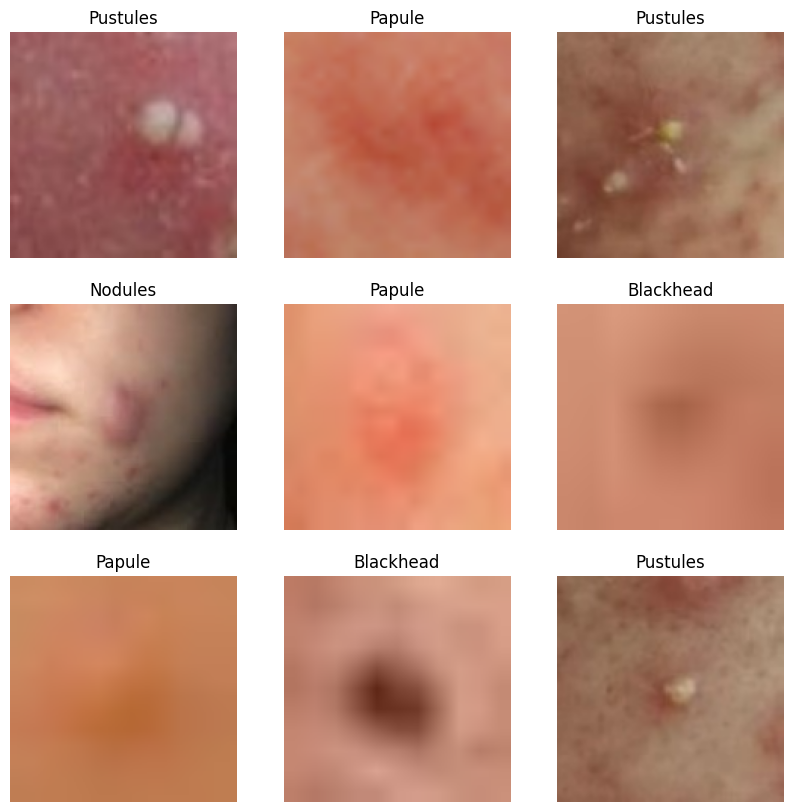

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# **Data Augmentation**

In [ ]:
data_augmentation = keras.Sequential([
  keras.layers.RandomFlip("horizontal_and_vertical",seed=0),
  keras.layers.RandomRotation(0.1,seed=0),
  keras.layers.RandomZoom(height_factor=0.2, width_factor=0.2)
])

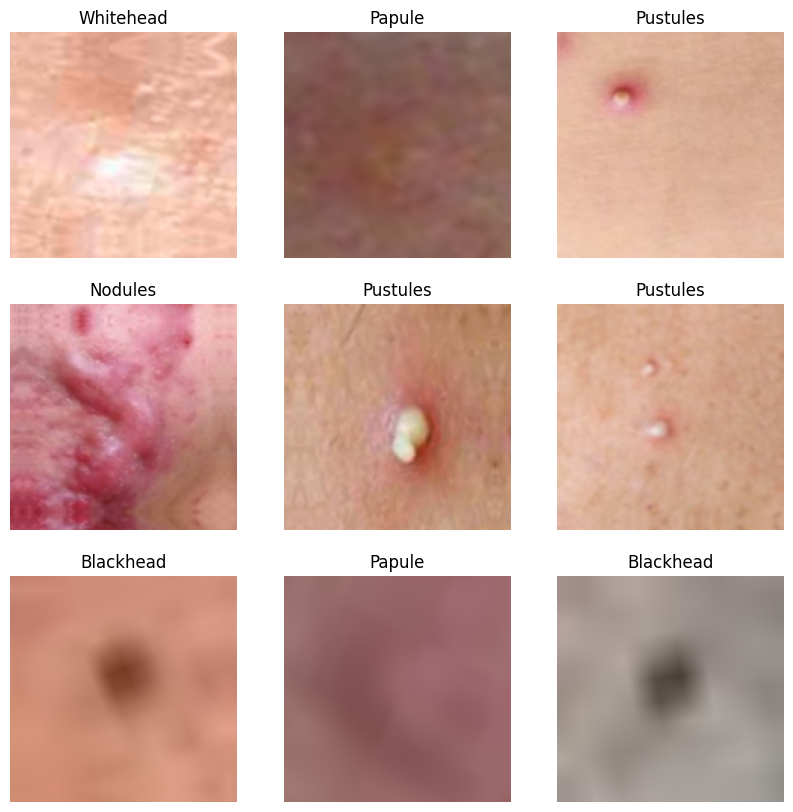

In [ ]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    augmented_image = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_image[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
augmented_train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# **Model**

In [ ]:
model = keras.Sequential([
  keras.layers.Rescaling(1./255),
  keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(64, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Conv2D(128, (3, 3), activation='relu'),
  keras.layers.MaxPooling2D(),
  keras.layers.Flatten(),
  keras.layers.Dense(512, activation='relu'),
  keras.layers.Dense(5,activation='softmax')
])

model.compile(
  optimizer=tf.keras.optimizers.Adam(learning_rate=3e-4),
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

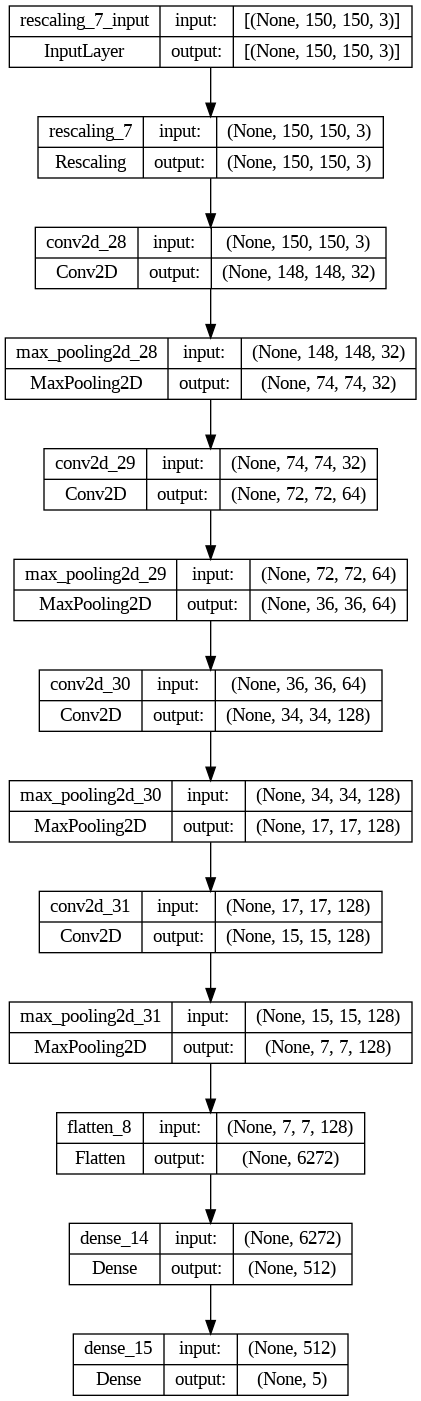

In [ ]:
model.build((None, 150, 150, 3))
tf.keras.utils.plot_model(model, to_file='model_flowchart.png', show_shapes=True, show_layer_names=True)

In [ ]:
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_7 (Rescaling)     (None, 150, 150, 3)       0         
                                                                 
 conv2d_28 (Conv2D)          (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 74, 74, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_29 (MaxPoolin  (None, 36, 36, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_30 (Conv2D)          (None, 34, 34, 128)      

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

In [ ]:
hist = model.fit(
    augmented_train_ds,
    validation_data=val_ds,
    epochs=100,
    class_weight=cw,
    shuffle=False,
    callbacks=[checkpoint]
)

Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


9/9 [==============================] - ETA: 0s - loss: 1.6020 - accuracy: 0.2278
Epoch 1: val_accuracy improved from -inf to 0.31395, saving model to best_model.h5
9/9 [==============================] - 19s 2s/step - loss: 1.6020 - accuracy: 0.2278 - val_loss: 1.5362 - val_accuracy: 0.3140
Epoch 2/100
9/9 [==============================] - ETA: 0s - loss: 1.4772 - accuracy: 0.2548
Epoch 2: val_accuracy improved from 0.31395 to 0.34884, saving model to best_model.h5
9/9 [==============================] - 17s 2s/step - loss: 1.4772 - accuracy: 0.2548 - val_loss: 1.4623 - val_accuracy: 0.3488
Epoch 3/100
9/9 [==============================] - ETA: 0s - loss: 1.4254 - accuracy: 0.3359
Epoch 3: val_accuracy improved from 0.34884 to 0.45349, saving model to best_model.h5
9/9 [==============================] - 18s 2s/step - loss: 1.4254 - accuracy: 0.3359 - val_loss: 1.4323 - val_accuracy: 0.4535
Epoch 4/100
9/9 [==============================] - ETA: 0s - loss: 1.4098 - accuracy: 0.3668
Epoc

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print('Loss:', loss)
print('Accuracy:', accuracy)

3/3 [==============================] - 3s 784ms/step - loss: 0.3692 - accuracy: 0.8953
Loss: 0.3692154288291931
Accuracy: 0.895348846912384


In [ ]:
model.save('acne_model_v2.h5')

<Axes: >

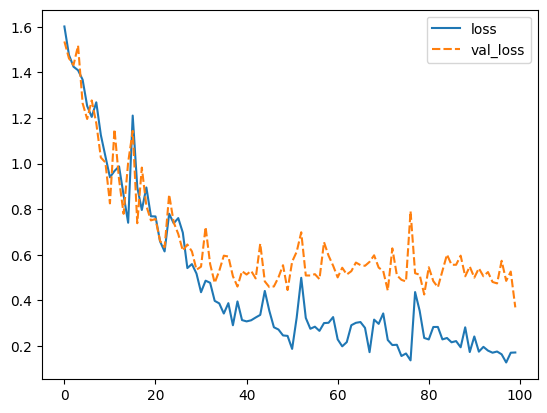

In [ ]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['loss', 'val_loss']})

<Axes: >

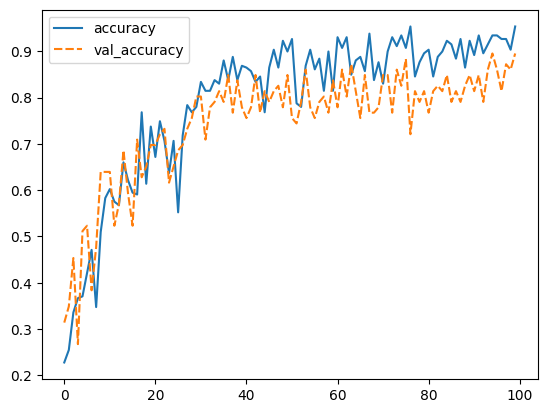

In [ ]:
sns.lineplot(data={idx: hist.history[idx] for idx in ['accuracy', 'val_accuracy']})

# **Confusion Matrix**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

from keras.layers import concatenate

predictions = np.array([])
true =  np.array([])

for x, y in val_ds:
  predictions = np.concatenate([predictions, np.argmax(model.predict(x), axis=-1)])
  true = np.concatenate([true, y.numpy()])

class_names = ['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead']
print(classification_report(true, predictions, target_names=class_names,digits =4))

1/1 [==============================] - 0s 392ms/step
              precision    recall  f1-score   support

   Blackhead     1.0000    1.0000    1.0000        10
     Nodules     0.7143    0.6667    0.6897        15
      Papule     0.9167    1.0000    0.9565        11
    Pustules     0.8750    0.8750    0.8750        32
   Whitehead     1.0000    1.0000    1.0000        18

    accuracy                         0.8953        86
   macro avg     0.9012    0.9083    0.9042        86
weighted avg     0.8930    0.8953    0.8938        86



In [ ]:
predictions

array([2., 0., 1., 3., 1., 4., 4., 3., 3., 3., 2., 1., 3., 2., 4., 3., 0.,
       2., 1., 1., 1., 3., 3., 4., 4., 0., 2., 3., 2., 3., 1., 4., 0., 3.,
       1., 1., 2., 1., 3., 4., 4., 3., 1., 0., 3., 2., 4., 3., 4., 0., 1.,
       0., 1., 3., 0., 0., 4., 3., 3., 2., 0., 3., 3., 4., 3., 4., 1., 2.,
       3., 3., 4., 3., 4., 3., 2., 3., 3., 4., 3., 2., 4., 4., 3., 3., 3.,
       3.])

In [ ]:
true

array([2., 0., 1., 3., 3., 4., 4., 3., 3., 3., 2., 3., 3., 2., 4., 3., 0.,
       2., 1., 1., 1., 3., 3., 4., 4., 0., 2., 1., 2., 3., 1., 4., 0., 3.,
       1., 3., 2., 3., 3., 4., 4., 3., 1., 0., 3., 2., 4., 1., 4., 0., 1.,
       0., 1., 3., 0., 0., 4., 3., 3., 2., 0., 1., 1., 4., 3., 4., 1., 2.,
       3., 3., 4., 3., 4., 3., 2., 3., 3., 4., 3., 1., 4., 4., 3., 3., 3.,
       3.])

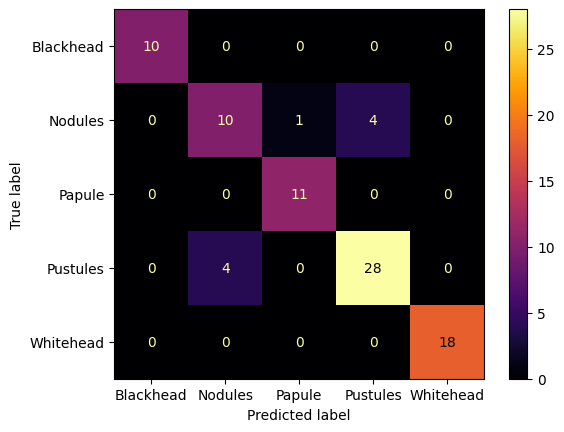

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(true, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=class_names)
disp.plot(cmap='inferno')
plt.savefig('confusionmatrix.png')
plt.show()

In [6]:
import numpy as np
np.random.seed(777)
import tensorflow as tf
np.random.seed(777)

from tensorflow import keras
from PIL import Image

def load_and_preprocess_image(image_path):
    image = Image.open(image_path)
    image = image.resize((150, 150))
    image = image.convert('RGB')
    image = np.array(image) / 1
    print(image.shape)
    return image

# Load the trained model
model = keras.models.load_model('/content/acne_model_v2 (1).h5')

# Preprocess the new image
image = load_and_preprocess_image('/content/WhatsApp Image 2023-06-15 at 19.45.03.jpg')  # Implement your own image loading and preprocessing function

# Reshape the image to match the input shape of the model
image = np.expand_dims(image,0)

# Make predictions
predictions = model.predict(image)
print(predictions)

# Get the predicted class label
predicted_class = np.argmax(predictions)

# Get the class name
class_names = ['Blackhead', 'Nodules', 'Papule', 'Pustules', 'Whitehead']  # Provide your own class names
predicted_class_name = class_names[predicted_class]

# Print the predicted class label and class name
print('Predicted class:', predicted_class)
print('Predicted class name:', predicted_class_name)

(150, 150, 3)
1/1 [==============================] - 0s 366ms/step
[[2.3090118e-04 2.3800785e-02 2.1535065e-03 4.9541849e-01 4.7839642e-01]]
Predicted class: 3
Predicted class name: Pustules
